In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Install dependencies

In [1]:
!pip install -q transformers datasets scikit-learn pandas numpy matplotlib seaborn

Imports

In [2]:
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup)
from torch.optim import AdamW

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


loading datasets

In [7]:
# --- Dreaddit (Stress) ---
stress_train = pd.read_csv("/kaggle/input/datasets/ruchi798/stress-analysis-in-social-media/dreaddit-train.csv")
stress_test  = pd.read_csv("/kaggle/input/datasets/ruchi798/stress-analysis-in-social-media/dreaddit-test.csv")
stress_df = pd.concat([stress_train, stress_test], ignore_index=True)
stress_df = stress_df[["text", "label"]].dropna()
stress_df["task"] = "stress"
print(f"Stress samples: {len(stress_df)} | Label dist:\n{stress_df.label.value_counts()}")

# --- Suicidal Ideation Reddit Dataset ---
suicide_df = pd.read_csv("/kaggle/input/datasets/rvarun11/suicidal-ideation-reddit-dataset/suicidal_ideation_reddit_annotated.csv")
print("Suicide dataset columns:", suicide_df.columns.tolist())
# Normalize — map whatever text/label columns exist
suicide_df = suicide_df.rename(columns={"usertext": "text"})

suicide_df = suicide_df[["text", "label"]].dropna()
suicide_df["task"] = "suicide"
print(f"Suicide samples: {len(suicide_df)} | Label dist:\n{suicide_df.label.value_counts()}")

Stress samples: 3553 | Label dist:
label
1    1857
0    1696
Name: count, dtype: int64
Suicide dataset columns: ['usertext', 'label']
Suicide samples: 12615 | Label dist:
label
1    6568
0    6047
Name: count, dtype: int64


EDA

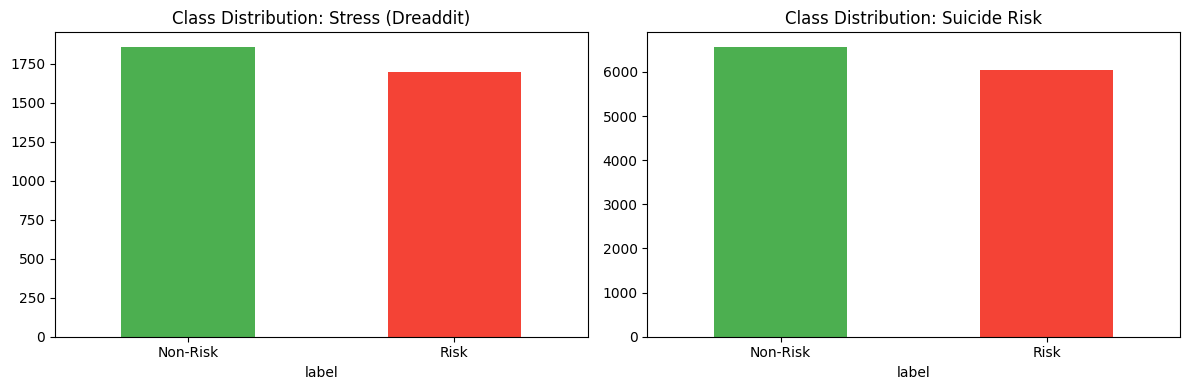

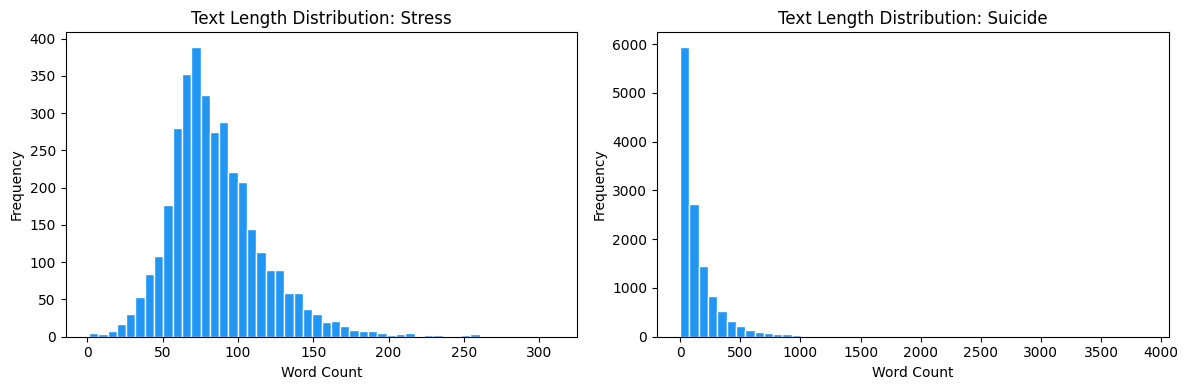

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (df, title) in zip(axes, [(stress_df, "Stress (Dreaddit)"),
                                   (suicide_df, "Suicide Risk")]):
    df["label"].value_counts().plot(kind="bar", ax=ax, color=["#4CAF50","#F44336"])
    ax.set_title(f"Class Distribution: {title}")
    ax.set_xticklabels(["Non-Risk","Risk"], rotation=0)
plt.tight_layout(); plt.savefig("class_distribution.png", dpi=150); plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (df, title) in zip(axes, [(stress_df, "Stress"), (suicide_df, "Suicide")]):
    df["text_len"] = df["text"].str.split().str.len()
    ax.hist(df["text_len"], bins=50, color="#2196F3", edgecolor="white")
    ax.set_title(f"Text Length Distribution: {title}")
    ax.set_xlabel("Word Count"); ax.set_ylabel("Frequency")
plt.tight_layout(); plt.savefig("text_length.png", dpi=150); plt.show()

DATASET CLASS

In [9]:
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels):
        self.enc = tokenizer(list(texts), truncation=True, padding="max_length",
                             max_length=MAX_LEN, return_tensors="pt")
        self.labels = torch.tensor(list(labels), dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {k: v[i] for k, v in self.enc.items()}, self.labels[i]


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train/evaluate helper

In [11]:
def train_eval(df, task_name, epochs=3, bs=32, lr=2e-5):
    print(f"\n{'='*50}\nTask: {task_name}\n{'='*50}")
    tr, te = train_test_split(df, test_size=0.2, random_state=SEED,
                              stratify=df["label"])
    tr, val = train_test_split(tr, test_size=0.1, random_state=SEED,
                               stratify=tr["label"])

    tr_ds  = MentalHealthDataset(tr["text"], tr["label"])
    val_ds = MentalHealthDataset(val["text"], val["label"])
    te_ds  = MentalHealthDataset(te["text"], te["label"])

    tr_dl  = DataLoader(tr_ds,  batch_size=bs, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=bs)
    te_dl  = DataLoader(te_ds,  batch_size=bs)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                num_labels=2).to(device)
    opt = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(tr_dl) * epochs
    sched = get_linear_schedule_with_warmup(opt, int(0.1*total_steps), total_steps)

    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    for epoch in range(epochs):
        # -- Train --
        model.train(); tr_loss = 0
        for batch, labels in tr_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = labels.to(device)
            out = model(**batch, labels=labels)
            loss = out.loss
            loss.backward(); opt.step(); sched.step(); opt.zero_grad()
            tr_loss += loss.item()
        tr_loss /= len(tr_dl)

        # -- Validate --
        model.eval(); val_loss = 0; all_preds, all_labels = [], []
        with torch.no_grad():
            for batch, labels in val_dl:
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = labels.to(device)
                out = model(**batch, labels=labels)
                val_loss += out.loss.item()
                preds = out.logits.argmax(-1).cpu().numpy()
                all_preds.extend(preds); all_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_dl)
        val_f1 = f1_score(all_labels, all_preds, average="weighted")
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {tr_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    # -- Test --
    model.eval(); all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch, labels in te_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            probs = torch.softmax(out.logits, -1)[:,1].cpu().numpy()
            preds = out.logits.argmax(-1).cpu().numpy()
            all_preds.extend(preds); all_labels.extend(labels.numpy())
            all_probs.extend(probs)

    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="weighted")
    auc = roc_auc_score(all_labels, all_probs)
    print(f"\nTest Accuracy: {acc:.4f} | Weighted F1: {f1:.4f} | AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=["Non-Risk","Risk"]))

    # -- Plots --
    # Loss curve
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history["train_loss"], label="Train"); ax[0].plot(history["val_loss"], label="Val")
    ax[0].set_title(f"{task_name}: Loss Curve"); ax[0].legend()
    ax[1].plot(history["val_f1"], color="green")
    ax[1].set_title(f"{task_name}: Val F1"); ax[1].set_ylabel("F1")
    plt.tight_layout()
    plt.savefig(f"{task_name.lower()}_training.png", dpi=150); plt.show()

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Risk","Risk"],
                yticklabels=["Non-Risk","Risk"])
    plt.title(f"{task_name}: Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{task_name.lower()}_cm.png", dpi=150); plt.show()

    # Save model
    model.save_pretrained(f"/kaggle/working/{task_name.lower()}_model")
    tokenizer.save_pretrained(f"/kaggle/working/{task_name.lower()}_model")

    return {"accuracy": acc, "f1": f1, "auc": auc}

training


Task: Stress


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch 1/3 | Train Loss: 0.5645 | Val Loss: 0.4650 | Val F1: 0.7632
Epoch 2/3 | Train Loss: 0.3844 | Val Loss: 0.4176 | Val F1: 0.8021
Epoch 3/3 | Train Loss: 0.2758 | Val Loss: 0.4057 | Val F1: 0.8207

Test Accuracy: 0.8143 | Weighted F1: 0.8142 | AUC-ROC: 0.8876

Classification Report:
              precision    recall  f1-score   support

    Non-Risk       0.81      0.79      0.80       339
        Risk       0.82      0.83      0.82       372

    accuracy                           0.81       711
   macro avg       0.81      0.81      0.81       711
weighted avg       0.81      0.81      0.81       711



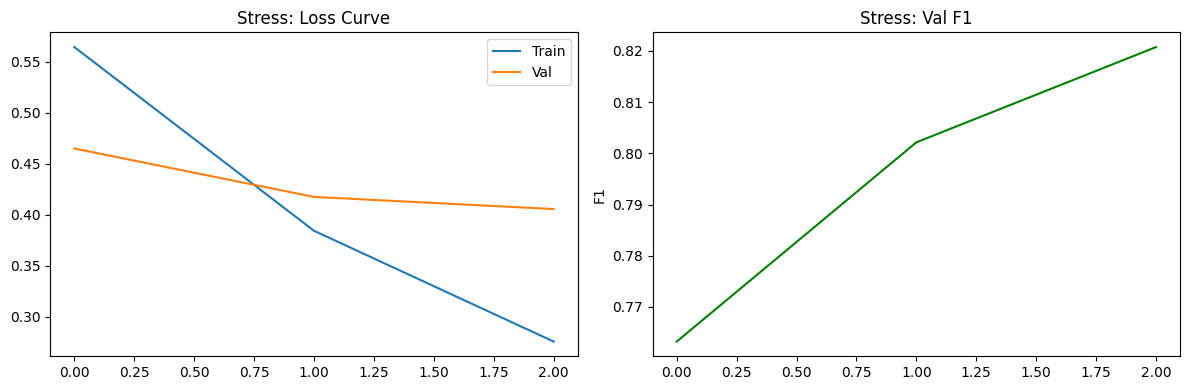

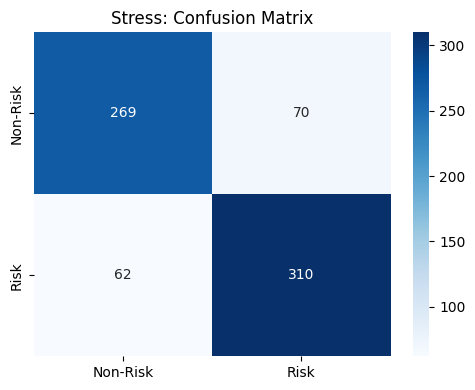

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Task: Suicide


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch 1/3 | Train Loss: 0.3578 | Val Loss: 0.2565 | Val F1: 0.9016
Epoch 2/3 | Train Loss: 0.2220 | Val Loss: 0.2469 | Val F1: 0.9063
Epoch 3/3 | Train Loss: 0.1753 | Val Loss: 0.2496 | Val F1: 0.8997

Test Accuracy: 0.9080 | Weighted F1: 0.9076 | AUC-ROC: 0.9639

Classification Report:
              precision    recall  f1-score   support

    Non-Risk       0.95      0.85      0.90      1209
        Risk       0.88      0.96      0.92      1314

    accuracy                           0.91      2523
   macro avg       0.91      0.91      0.91      2523
weighted avg       0.91      0.91      0.91      2523



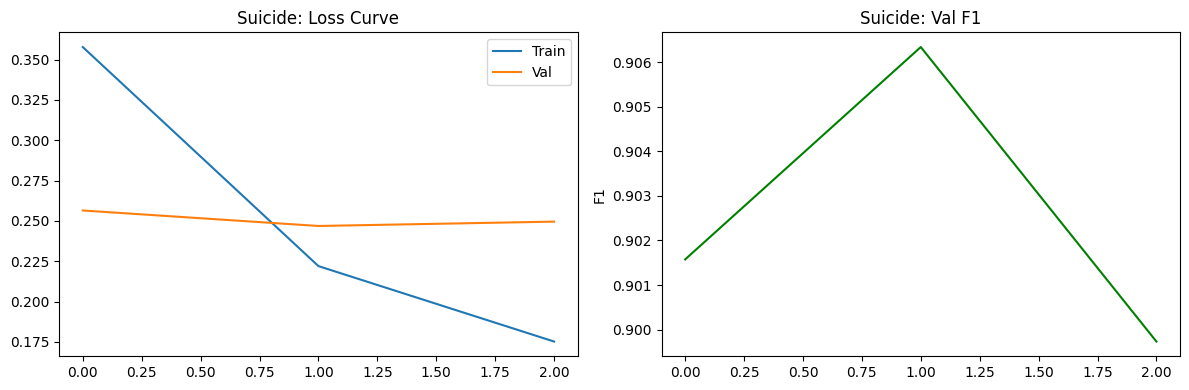

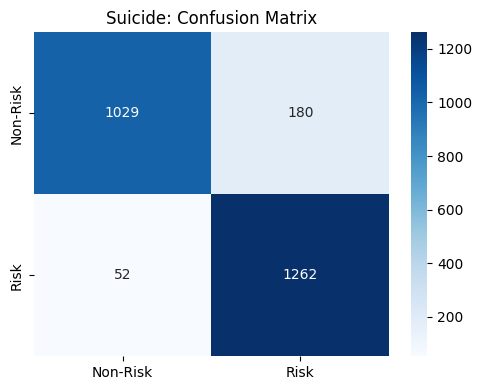

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
stress_results  = train_eval(stress_df,  "Stress",  epochs=3)
suicide_results = train_eval(suicide_df, "Suicide", epochs=3)

Baseline Comparison

In [13]:
from textblob import TextBlob
from sklearn.metrics import f1_score as skf1

def textblob_baseline(df):
    preds = [1 if TextBlob(t).sentiment.polarity < 0 else 0 for t in df["text"]]
    return skf1(df["label"], preds, average="weighted")

_, te_stress  = train_test_split(stress_df,  test_size=0.2, random_state=SEED, stratify=stress_df["label"])
_, te_suicide = train_test_split(suicide_df, test_size=0.2, random_state=SEED, stratify=suicide_df["label"])

bl_stress  = textblob_baseline(te_stress)
bl_suicide = textblob_baseline(te_suicide)

print("\n" + "="*50)
print("FINAL COMPARISON TABLE")
print("="*50)
results_df = pd.DataFrame({
    "Task":     ["Stress Detection", "Suicide Risk Detection"],
    "Baseline (TextBlob) F1": [round(bl_stress,4), round(bl_suicide,4)],
    "DistilBERT F1":  [round(stress_results["f1"],4),  round(suicide_results["f1"],4)],
    "DistilBERT AUC": [round(stress_results["auc"],4), round(suicide_results["auc"],4)],
    "Accuracy":       [round(stress_results["accuracy"],4), round(suicide_results["accuracy"],4)],
})
print(results_df.to_string(index=False))
results_df.to_csv("/kaggle/working/results_summary.csv", index=False)


FINAL COMPARISON TABLE
                  Task  Baseline (TextBlob) F1  DistilBERT F1  DistilBERT AUC  Accuracy
      Stress Detection                  0.5947         0.8142          0.8876    0.8143
Suicide Risk Detection                  0.5866         0.9076          0.9639    0.9080


Summary Plot

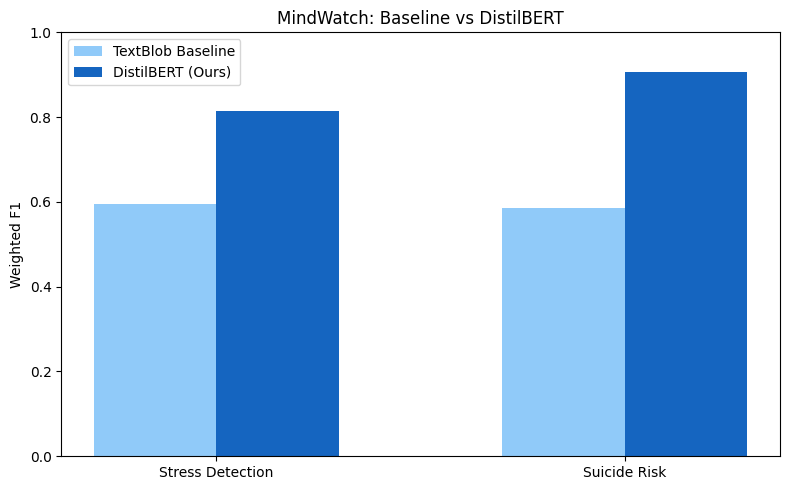


All outputs saved to /kaggle/working/


In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(2)
w = 0.3
ax.bar(x - w/2, [bl_stress, bl_suicide], w, label="TextBlob Baseline", color="#90CAF9")
ax.bar(x + w/2, [stress_results["f1"], suicide_results["f1"]], w,
       label="DistilBERT (Ours)", color="#1565C0")
ax.set_xticks(x); ax.set_xticklabels(["Stress Detection", "Suicide Risk"])
ax.set_ylabel("Weighted F1"); ax.set_title("MindWatch: Baseline vs DistilBERT")
ax.set_ylim(0, 1); ax.legend()
plt.tight_layout(); plt.savefig("comparison.png", dpi=150); plt.show()

print("\nAll outputs saved to /kaggle/working/")